# 주제 : 추천 시스템 - 영화 데이터셋과 Embedding & Ranking 알고리즘으로 추천시스템 만들기
----------

## 데이터 소개
    - 이번 주제도 마찬가지로 MovieLens Dataset을 사용합니다.
    - 같은 데이터라도 상황과 데이터의 크기에 따라 다양한 추천 방법을 활용할 수 있어야 합니다.
    - 파일은 세 개 이며, 각각의 컬럼은 아래와 같습니다.
    
    1. ratings.dat
    user_id : 영화를 시청한 사용자 아이디
    movie_id : 영화의 아이디
    rating : 사용자가 영화를 평가한 점수
    time : 사용자가 영화를 시청한 시간
    
    2. movies.dat
    movie_id : 영화의 아이디
    title : 영화 제목
    genre : 영화 장르

    3. users.dat
    user_id : 사용자 아이디
    gender : 사용자 성별
    age : 사용자 나이
    occupation : 사용자 직업코드
    zipcode : 사용자 거주코드

    
- 데이터 출처: https://grouplens.org/datasets/movielens/


## 최종 목표
    - Large-Scale 에서 적용 가능한 추천시스템 구조 이해
    - Word2Vec 기반의 임베딩 모델 이해
    - EDA로 수행할 수 있는 다양한 인사이트 활용
    - Point-wise 모델링에 대한 이해
    - Factorization Machine 알고리즘에 대한 이해
    - ML에 활용할 수 있는 데이터 변환 능력 습득
    - 모델의 추천 결과를 평가하는 방법에 대한 연습

## Step 1. Word2Vec 알고리즘 기반 추천 후보군 생성

#### Rating Matrix 기반 추천시스템의 한계

    [Memory Based Recommendations]
    1. 만약 유저, 영화의 수가 3000이 아니라 3천만 개 라면?
    2. Matrix의 크기는 30,000,000 X 30,000,000
    3. 연산량 자체도 문제가 되지만, Extreme Sparse 벡터가 되면서 정확도 역시 현저하게 떨어지게 됨
    4. 차원축소, ALS 등의 방법으로 어느정도 극복할 수 있지만, 근본적인 해결책이 되지는 못함

- Recommendation in Large Scale System
  - Architecture
  ![recsys_architecture](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2F30pCp%2Fbtqv7PV6365%2FCkl5dwvSoQF3RdneCIzGr1%2Fimg.png)
  - 데이터 수집과 처리 단계를 제외하면, 추천시스템은 다음과 같은 레이어로 구분되는 추세
    - `Generate Candidates` : 수백, 수천만개의 Item 중, 후보가 될 만한 Item을 추출. 여기에 CF 등의 방법을 사용할 수도 있지만, 일반적으로는 연산량이 작은 여러 개의 전략(시나리오)들을 합쳐서 coverage 자체를 확보하는 역할을 함. 예를 들면 인기도가 높은 Item, 연관성이 높은 Item 등을 별개의 전략으로 추출하는 것.
    - `Intention Predict` : User의 Context에 기반하여 Candidates를 한 번 더 좁혀주는 역할. 반드시 필요한 단계는 아니며, Candidates를 추렸음에도 여전히 Large Scale 문제를 가지고 있는 경우에 필터링의 역할로 사용할 수 있음.
    - `Personalized Ranking` : 일반적으로 추천시스템에서 추천이 잘 되었는지를 평가하는 지표는 CTR, CVR 같은 지표. 이 지표들을 Maximize 할 수 있는 방법으로 개인화 모델을 학습. 일반적인 Classifier를 생각해도 무방하며, 학습 데이터셋을 잘 구축하는 것이 좋은 추천 랭킹모델을 만드는 것.

![recsys_architecture2](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FUsbKo%2Fbtqv7PBN46z%2Fd4m5pf7lrKs1CqxzkROY81%2Fimg.png)


-----

#### Word2Vec 기반의 Movie2Vec 만들기

    [Word2Vec]
    1. 임베딩(Embedding) 방법론 중 가장 대중적이고 성능이 좋은 방법
    2. 같은 문장 내, 혹은 비슷한 위치에 등장하는 단어들은 유사한 의미를 가지고 있을 것이라는 가정.
    3. 원래는 단어를 벡터로 표현하는 방법으로 고안되었지만, word2vec의 메커니즘을 다양하게 활용할 수 있음
    4. Word2Vec은 중심 단어와 주변 단어와의 연관성을 학습하여 벡터로 표현함.
      - 예시 문장 : "역시 성공은 고난을 동반 말없이 등산을 등반하는 것처럼"
      - 만약 "성공"이라는 단어를 중심 단어로 활용한다면, [역시, _, 고난을, 동반] 이러한 주변 단어를 가지고 중심에 있는 단어의 벡터를 학습할 수 있게 됨. (Skip-gram 방식. CBOW는 반대)

![skipgram](http://i.imgur.com/TupGxMl.png)

    [학습 원리]
    1. 단어셋의 크기를 dim으로 하는 input/output 벡터를 활용하여 softmax classification
    2. 따라서 아래 함수를 최소화 하는 것을 목표로 하는 network를 학습하게 됨

![function](https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/images/function.png)

    [벡터 표현]
    1. 학습된 네트워크의 hidden layer (projection layer)에 단어의 벡터가 표현됨
    2. 이를 lookup 이라고 함

![lookup](https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/images/lookup.png)

-----

    [영화의 벡터 표현]
    1. word2vec 방법에서 word를 item으로 치환하면, item2vec으로 활용할 수 있음 (많은 추천시스템에서 활용하는 방법)
    2. 단, 이 방법은 데이터의 meta-data가 하나의 축으로 이루어진 단어에서와 달리, 영화처럼 multi-axis meta-data를 가진 데이터에서는 완전한 표현이라고 볼 수 없음 (ex. 장르, 감독 등등의 정보)
    3. 또한 item2vec 메커니즘을 추천시스템에 활용하면 필연적으로 cold-start 문제가 발생할 수 있음
    4. `Cold-start Problem` : 새로운 유저나 새로운 아이템을 대상으로 추천하게 될 때, 기존 학습모델에서는 등장한 적 없는 데이터이기 때문에 추천 대상으로 포함되기 어려운 현상
    5. 임베딩 기반 추천에서 cold-start를 극복하는 방법은 여러가지가 있지만, 그 중에서 가장 적용하기 간단하면서도 중요한 개념을 담고 있는 meta-prod2vec을 활용
    6. 자세한 내용 : https://arxiv.org/pdf/1607.07326.pdf

![meta-prod2vec](https://image.slidesharecdn.com/metaprod2vec-161007133531/95/metaprod2vec-simple-product-embeddings-with-sideinformation-36-638.jpg?cb=1475847427)

### 문제 1. 데이터 불러오기

In [1]:
import pandas as pd

rating_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/ratings.dat'
rating_df = pd.io.parsers.read_csv(rating_url, names=['user_id', 'movie_id', 'rating', 'time'], delimiter='::', engine ='python')

movie_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/movies.dat'
movie_df = pd.io.parsers.read_csv(movie_url, names=['movie_id', 'title', 'genre'], delimiter='::', engine ='python', encoding='ISO-8859-1')

user_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/users.dat'
user_df = pd.io.parsers.read_csv(user_url, names=['user_id', 'gender', 'age', 'occupation', 'zipcode'], delimiter='::', engine ='python')

### 문제 2. EDA & 전처리 - 사용자별 시청 목록 추출

In [2]:
def get_list_sort(x):
  return x.sort_values(['time'])['movie_id'].tolist()

user_watch_list = rating_df.groupby('user_id').apply(lambda x: get_list_sort(x))

<ipython-input-2-21c8e929813f>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_watch_list = rating_df.groupby('user_id').apply(lambda x: get_list_sort(x))


In [3]:
user_watch_list

,0
user_id,
1,"[3186, 1721, 1022, 1270, 2340, 1836, 3408, 120..."
2,"[1198, 1217, 1210, 2717, 1293, 2943, 1225, 119..."
3,"[593, 2858, 3534, 1968, 1961, 1431, 1266, 1378..."
4,"[1210, 1097, 3468, 3527, 480, 260, 1196, 1198,..."
5,"[2717, 919, 908, 356, 1250, 2188, 2858, 1127, ..."
...,...
6036,"[1721, 2376, 3438, 2428, 1883, 2492, 2827, 268..."
6037,"[1882, 2028, 1267, 702, 3508, 562, 3148, 858, ..."
6038,"[920, 3396, 1210, 2146, 356, 1387, 1079, 1148,..."


In [4]:
rating_df['movie_id'].value_counts()

,count
movie_id,
2858,3428
260,2991
1196,2990
1210,2883
480,2672
...,...
3458,1
2226,1
1815,1


<Axes: >

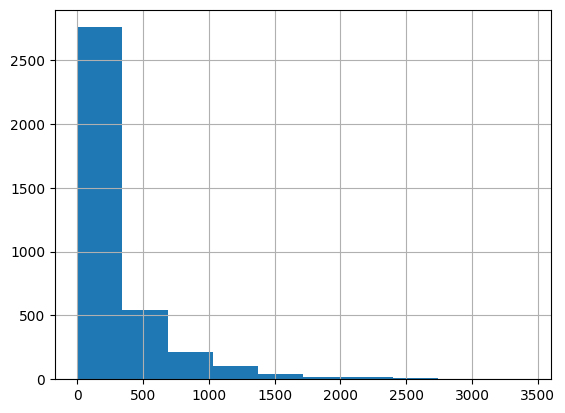

In [5]:
rating_df['movie_id'].value_counts().hist(bins=10)

### 문제 3. EDA & 전처리 - 영화 개봉년도 피쳐 생성

In [6]:
movie_df.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
# title 피처에서 개봉 년도 (ex. 1990, 2000...) 분리

movie_df['year'] = movie_df['title'].apply(lambda x: x[-5:-2]+"0")
movie_df.head()

,movie_id,title,genre,year
0,1,Toy Story (1995),Animation|Children's|Comedy,1990
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1990
2,3,Grumpier Old Men (1995),Comedy|Romance,1990
3,4,Waiting to Exhale (1995),Comedy|Drama,1990
4,5,Father of the Bride Part II (1995),Comedy,1990


<Axes: xlabel='year'>

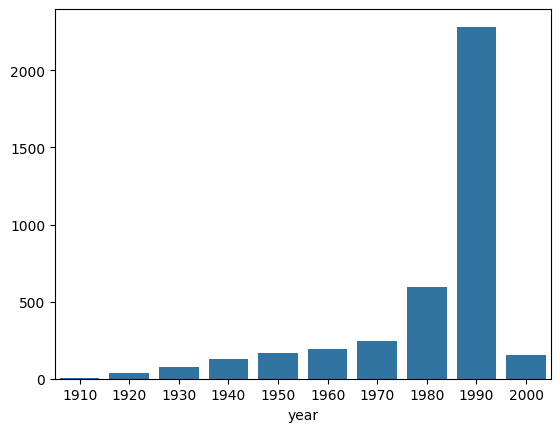

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.barplot으로 개봉 년도별 영화 갯수 시각화
year = movie_df['year'].value_counts().sort_values().sort_index()
sns.barplot(x=year.index, y=year.values)

### 문제 4. EDA & 전처리 - 영화 장르 피쳐 생성

In [9]:
movie_df['genre'].value_counts()

,count
genre,
Drama,843
Comedy,521
Horror,178
Comedy|Drama,162
Comedy|Romance,142
...,...
Action|Comedy|Crime|Horror|Thriller,1
Action|Drama|Thriller|War,1
Action|Adventure|Children's,1


<Axes: >

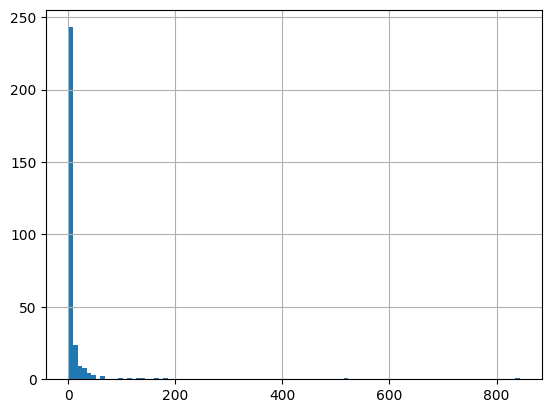

In [10]:
movie_df['genre'].value_counts().hist(bins=100)

In [11]:
# genre 피처에서 영화의 대표 장르 추출

movie_df['main_genre'] = movie_df['genre'].apply(lambda x: x.split('|')[0])
movie_df['main_genre'].value_counts()

,count
main_genre,
Drama,1176
Comedy,1024
Action,503
Horror,262
Adventure,155
Crime,131
Documentary,123
Thriller,101
Animation,90


### 문제 5. Embedding - EDA 결과를 활용하여 Movie2Vec 학습

In [12]:
movie_df.head()

,movie_id,title,genre,year,main_genre
0,1,Toy Story (1995),Animation|Children's|Comedy,1990,Animation
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1990,Adventure
2,3,Grumpier Old Men (1995),Comedy|Romance,1990,Comedy
3,4,Waiting to Exhale (1995),Comedy|Drama,1990,Comedy
4,5,Father of the Bride Part II (1995),Comedy,1990,Comedy


In [13]:
# movie_meta_dict 생성

movie_meta_dict = movie_df.set_index('movie_id')[['year','main_genre']].to_dict()

In [14]:
# Gensim을 활용한 meta-prod2vec을 학습할 수 있는 데이터셋 생성

# ex. [['movie_id:3186', 'year:1990', 'genre:Drama', 'movie_id:1721',
#       'year:1990', 'genre:Drama', 'movie_id:1022', 'year:1950',
#       'genre:Animation', 'movie_id:1270', 'year:1980', 'genre:Comedy', 'movie_id:2340'...]]
movie2vec_dataset = []
for movie_list in user_watch_list:
  meta_list = []
  for movie_id in movie_list:
    word_meta_1 = 'movie_id:' + str(movie_id)
    word_meta_2 = 'year:' + movie_meta_dict['year'][movie_id]
    word_meta_3 = 'genre' + movie_meta_dict['main_genre'][movie_id]
    meta_list.append(word_meta_1)
    meta_list.append(word_meta_2)
    meta_list.append(word_meta_3)
  movie2vec_dataset.append(meta_list)

In [15]:
movie2vec_dataset

Output hidden; open in https://colab.research.google.com to view.

In [16]:
# !pip install --upgrade numpy

In [17]:
# !pip install gensim

In [18]:
from gensim.models import Word2Vec

model = Word2Vec(movie2vec_dataset,
                 vector_size=100,
                 window=6,  # 주변 word의 윈도우
                 sg=1,  # skip-gram OR cbow
                 hs=0,  # hierarchical softmax OR negative sampling
                 negative=20,  # negative sampling 파라미터
                 min_count=1,  # word의 등장 최소 횟수
                 epochs=20)

### 문제 6. Embedding - 일부 데이터로 Movie2Vec 학습 결과 확인

In [19]:
model.wv.vectors.shape

(3734, 100)

In [20]:
# most_similar 함수로 학습 결과 확인
model.wv.most_similar("movie_id:1", topn=5)

[('movie_id:1223', 0.8314626216888428),
 ('movie_id:3429', 0.7660949230194092),
 ('movie_id:2324', 0.7221856117248535),
 ('movie_id:1537', 0.6816290020942688),
 ('movie_id:2289', 0.6781054139137268)]

In [21]:
movie_df[movie_df['movie_id'].isin([1223,3429,2324,745,2289])]

,movie_id,title,genre,year,main_genre
735,745,"Close Shave, A (1995)",Animation|Comedy|Thriller,1990,Animation
1205,1223,"Grand Day Out, A (1992)",Animation|Comedy,1990,Animation
2220,2289,"Player, The (1992)",Comedy|Drama,1990,Comedy
2255,2324,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama,1990,Comedy
3360,3429,Creature Comforts (1990),Animation|Comedy,1990,Animation


### 문제 7. EDA & 전처리 - Movie2Vec 모델로 Item2Item 후보군 생성

In [22]:
# item to item 후보군 생성할 변수
item2item = {}

# 영화별 연관 영화 k개씩 추출
k = 10
not_in_count = 0

for movie_id in movie_df['movie_id'].values:
   # item to item 후보군 추출
   item2item[movie_id] = []
   try:
    sim_list = model.wv.most_similar("movie_id:" + str(movie_id), topn=k+10)
    for movie_tup in sim_list:
      tup_info= movie_tup[0].split(':')
      if (tup_info[0] == 'movie_id') and (len(item2item[movie_id]) < 10):
        item2item[movie_id].append(tup_info[1])
   except:
      not_in_count += 1
      print('word', str(movie_id),'not in vocabulary')

word 51 not in vocabulary
word 109 not in vocabulary
word 115 not in vocabulary
word 143 not in vocabulary
word 284 not in vocabulary
word 285 not in vocabulary
word 395 not in vocabulary
word 399 not in vocabulary
word 400 not in vocabulary
word 403 not in vocabulary
word 604 not in vocabulary
word 620 not in vocabulary
word 625 not in vocabulary
word 629 not in vocabulary
word 636 not in vocabulary
word 654 not in vocabulary
word 675 not in vocabulary
word 676 not in vocabulary
word 683 not in vocabulary
word 693 not in vocabulary
word 699 not in vocabulary
word 713 not in vocabulary
word 721 not in vocabulary
word 723 not in vocabulary
word 727 not in vocabulary
word 738 not in vocabulary
word 739 not in vocabulary
word 752 not in vocabulary
word 768 not in vocabulary
word 770 not in vocabulary
word 772 not in vocabulary
word 773 not in vocabulary
word 777 not in vocabulary
word 794 not in vocabulary
word 795 not in vocabulary
word 797 not in vocabulary
word 812 not in vocabulary
wo

In [23]:
print("total:", not_in_count)

total: 177


In [24]:
str(item2item)[:100]

"{1: ['1223', '3429', '2324', '1537', '2289', '1148', '745', '3114', '34', '1265'], 2: ['60', '3489',"

## Step 2. 탐색적으로 다양한 추천 후보군 생성

### 문제 8. EDA & 전처리 - 평균 평점 기반 Popular 후보군 생성

In [25]:
# 일정 count 이상이면서 평균 rating이 높은 순서대로 Popular 후보군 생성 (movie_id에 groupby 적용)

mean_rating = rating_df.groupby('movie_id')['rating'].agg(['mean','count'])

In [26]:
mean_rating.head()

,mean,count
movie_id,,
1,4.146846,2077
2,3.201141,701
3,3.016736,478
4,2.729412,170
5,3.006757,296


In [27]:
mean_rating['count'].value_counts()

,count
count,
1,114
2,89
4,45
3,42
5,39
...,...
593,1
2583,1
997,1


<Axes: >

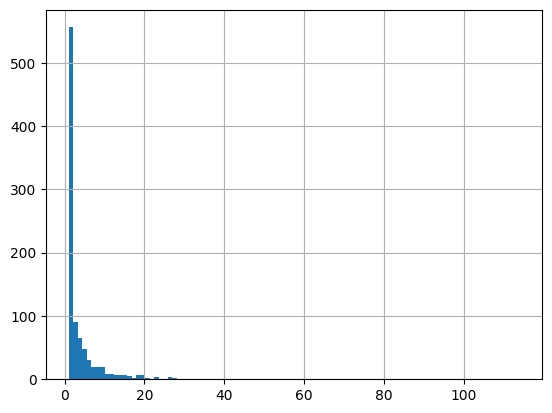

In [28]:
mean_rating['count'].value_counts().hist(bins=100)

In [29]:
mean_rating[mean_rating['count'] > 10]['mean'].sort_values(ascending=False)

,mean
movie_id,
2905,4.608696
2019,4.560510
318,4.554558
858,4.524966
745,4.520548
...,...
3573,1.461538
1323,1.372093
1739,1.361702


### 문제 9. EDA & 전처리 - Popular 후보군 생성 결과 확인

In [30]:
# 생성 결과를 popular_movie_list 변수에 할당

popular_movie_list = mean_rating[mean_rating['count'] > 10]['mean'].sort_values(ascending=False).index[:10].tolist()

In [31]:
popular_movie_list

[2905, 2019, 318, 858, 745, 50, 527, 1148, 922, 1198]

### 문제 10. EDA & 전처리 - 장르 & 연도 기준 Meta2Item 후보군 생성

In [32]:
merge_df = pd.merge(mean_rating, movie_df, on='movie_id')
merge_df.head()

,movie_id,mean,count,title,genre,year,main_genre
0,1,4.146846,2077,Toy Story (1995),Animation|Children's|Comedy,1990,Animation
1,2,3.201141,701,Jumanji (1995),Adventure|Children's|Fantasy,1990,Adventure
2,3,3.016736,478,Grumpier Old Men (1995),Comedy|Romance,1990,Comedy
3,4,2.729412,170,Waiting to Exhale (1995),Comedy|Drama,1990,Comedy
4,5,3.006757,296,Father of the Bride Part II (1995),Comedy,1990,Comedy


In [33]:
# 장르&연도를 meta로 하여, meta별 상위 10개의 평점 높은 영화
# popular list 추출

def get_meta_popular_list(x, k):
  movie_id_list = x.sort_values(by=['mean'], ascending=False)['movie_id'].tolist()
  return movie_id_list[:k]

genre_popular = merge_df.groupby('main_genre').apply(lambda x: get_meta_popular_list(x, k=10))
year_popular = merge_df.groupby('year').apply(lambda x: get_meta_popular_list(x, k=10))

<ipython-input-33-aee5156a703c>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  genre_popular = merge_df.groupby('main_genre').apply(lambda x: get_meta_popular_list(x, k=10))
<ipython-input-33-aee5156a703c>:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  year_popular = merge_df.groupby('year').apply(lambda x: get_meta_popular_list(x, k=10))


In [34]:
genre_popular.head()

,0
main_genre,
Action,"[2905, 2019, 858, 1198, 260, 1221, 2028, 2571,..."
Adventure,"[3172, 1204, 1262, 3470, 1254, 919, 1303, 1259..."
Animation,"[745, 1148, 720, 1223, 3429, 3114, 1, 741, 276..."
Children's,"[1097, 1028, 34, 262, 3396, 755, 531, 3397, 55..."
Comedy,"[1830, 3233, 3607, 3030, 3307, 3022, 1136, 341..."


In [35]:
year_popular.head()

,0
year,
1910,"[3132, 2821, 2823]"
1920,"[3517, 3022, 3629, 2010, 3232, 1348, 3742, 330..."
1930,"[3382, 3307, 3134, 1260, 905, 919, 954, 950, 3..."
1940,"[3656, 1212, 3435, 912, 913, 923, 3089, 1284, ..."
1950,"[3172, 2019, 922, 904, 1178, 670, 668, 1250, 9..."


### 문제 11. EDA & 전처리 - Meta 후보군 생성 결과 확인

In [36]:
genre_popular_dict = genre_popular.to_dict()
genre_popular_dict

{'Action': [2905, 2019, 858, 1198, 260, 1221, 2028, 2571, 1197, 1233],
 'Adventure': [3172, 1204, 1262, 3470, 1254, 919, 1303, 1259, 29, 1931],
 'Animation': [745, 1148, 720, 1223, 3429, 3114, 1, 741, 2761, 1023],
 "Children's": [1097, 1028, 34, 262, 3396, 755, 531, 3397, 551, 1012],
 'Comedy': [1830, 3233, 3607, 3030, 3307, 3022, 1136, 3410, 2324, 1234],
 'Crime': [3656, 50, 3517, 3435, 1260, 296, 1213, 1945, 608, 1617],
 'Documentary': [3881, 787, 3338, 2930, 128, 1147, 3679, 363, 1189, 2859],
 'Drama': [3382, 989, 3245, 53, 2503, 318, 527, 578, 2480, 439],
 'Fantasy': [792, 2021],
 'Film-Noir': [922, 913, 1252, 1267, 1284, 2186, 930, 541, 2203, 2066],
 'Horror': [3280, 1219, 1258, 1348, 2648, 1997, 2664, 1340, 1333, 2644],
 'Musical': [899, 914, 1947, 2565, 3606, 1035, 3545, 900, 3675, 2971],
 'Mystery': [904, 1212, 903, 950, 906, 1086, 2206, 1625, 931, 2467],
 'Romance': [928, 28, 932, 2708, 2721, 1684, 803, 2833, 3368, 976],
 'Sci-Fi': [750, 1199, 2010, 1206, 1301, 2660, 1921, 365

In [37]:
year_popular_dict = year_popular.to_dict()
year_popular_dict

{'1910': [3132, 2821, 2823],
 '1920': [3517, 3022, 3629, 2010, 3232, 1348, 3742, 3306, 1925, 3310],
 '1930': [3382, 3307, 3134, 1260, 905, 919, 954, 950, 3462, 1256],
 '1940': [3656, 1212, 3435, 912, 913, 923, 3089, 1284, 898, 953],
 '1950': [3172, 2019, 922, 904, 1178, 670, 668, 1250, 908, 2731],
 '1960': [3233, 3245, 2905, 557, 750, 1207, 3030, 1204, 1262, 1267],
 '1970': [3607, 3280, 858, 260, 1193, 1221, 1252, 1136, 3470, 1234],
 '1980': [1198, 3338, 1131, 1197, 1233, 2931, 1196, 1172, 1224, 3091],
 '1990': [989, 787, 1830, 53, 2503, 318, 745, 50, 527, 1148],
 '2000': [3881, 3888, 3897, 3949, 3578, 3911, 3647, 3353, 3851, 3317]}

## Step 3. Point-wise 데이터셋 생성

#### Ranking Model

    [랭킹 모델의 형태와 역할]
    1. Binary Classification을 학습하는 Regressor가 가장 대표적인 예
    2. y=1은 User가 Item을 시청(혹은 구매 등)한 경우 -> **Ground Truth**
    3. f(x_ui) = X_u + X_i + b -> **X_u는 User의 여러가지 정보를 벡터로 나타낸 것, 그리고 X_i는 아이템의 여러가지 정보를 벡터로 나타낸 것**
    4. NDCG, AUC, Top@Precision... 등을 기준으로 모델을 학습 (랭킹 학습 방식인 Point-wise, Pair-wise 등을 기준으로 각각 다름)

![point-wise](https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/images/point-wise.png)

### 문제 12. EDA & 전처리 - 특정 시간 기준 데이터셋 분리

In [38]:
tt = rating_df['time'].quantile(q=0.8, interpolation='nearest')
tt

975768738

In [39]:
train_df = rating_df[rating_df['time'] < tt]
test_df = rating_df[rating_df['time'] >= tt]

### 문제 13. User Profiling - 유저 속성 EDA (gender, age, occupation, zipcode)

##### 1) Gender

In [40]:
user_df.head()

,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


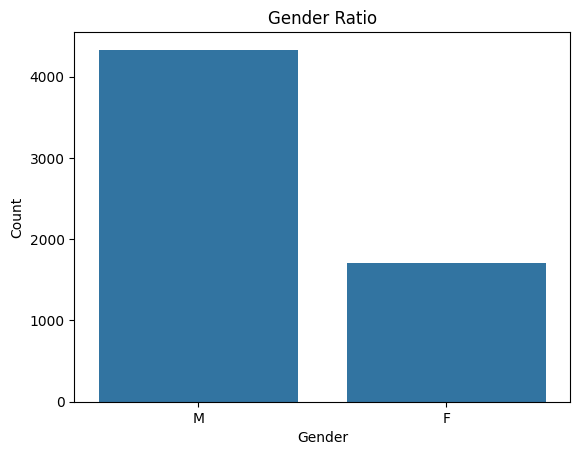

In [41]:
import matplotlib.pyplot as plt

gender = user_df['gender'].value_counts()
sns.barplot(x=gender.index, y=gender.values)
plt.title('Gender Ratio')
plt.ylabel('Count')
plt.xlabel('Gender')
plt.show()

#### 2) Age

<Axes: >

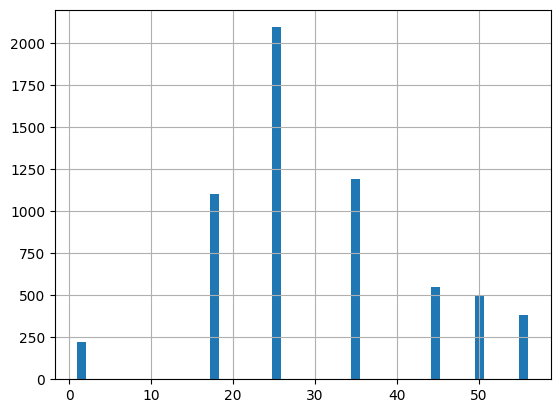

In [42]:
user_df['age'].hist(bins='auto')

In [43]:
user_df['age'].value_counts()

,count
age,
25,2096
35,1193
18,1103
45,550
50,496
56,380
1,222


In [44]:
def age_bucketize(age):
    if age == 1:
        return 'outlier'
    else:
        return str(age)[0] + "0"

user_df['age_bucket'] = user_df['age'].apply(lambda x: age_bucketize(x))
user_df['age_bucket'].value_counts()

,count
age_bucket,
20,2096
30,1193
10,1103
50,876
40,550
outlier,222


#### 3) Occupation

In [45]:
user_df['occupation'].value_counts()

,count
occupation,
4,759
0,711
7,679
1,528
17,502
12,388
14,302
20,281
2,267


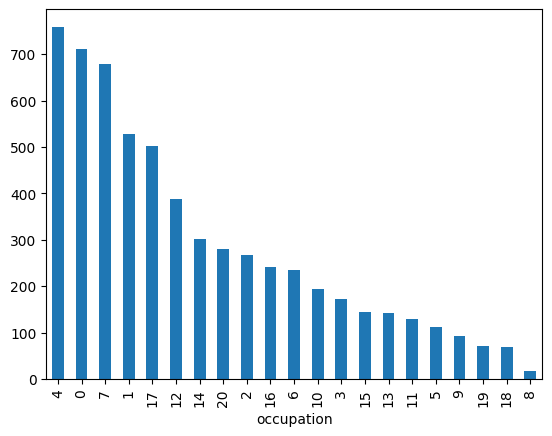

In [46]:
user_df['occupation'].value_counts().plot(kind='bar');

#### 4) Zipcode

In [47]:
user_df['zipcode'].value_counts()

,count
zipcode,
48104,19
22903,18
55104,17
94110,17
55455,16
...,...
80236,1
19428,1
33073,1


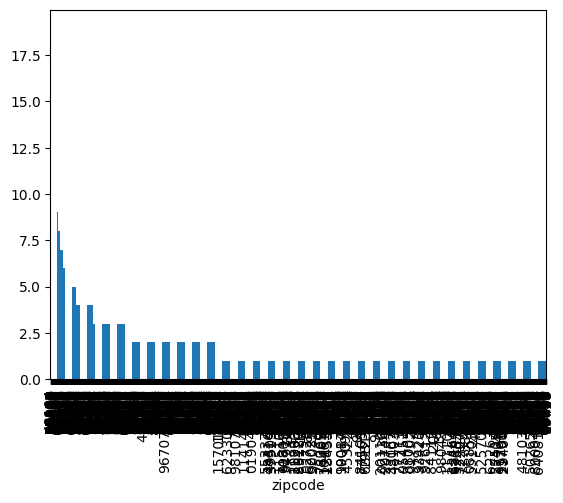

In [48]:
user_df['zipcode'].value_counts().plot(kind='bar');

### 문제 14. User Profiling - 유저 속성별 피쳐맵 생성

#### 1) Gender

In [49]:
# gender 피처맵 생성

gender_list = user_df['gender'].unique()
gender_index = {}
for idx, gender in enumerate(gender_list):
  gender_index[gender] = idx + 1

In [50]:
gender_index

{'F': 1, 'M': 2}

#### 2) Age

In [51]:
# age 피처맵 생성

age_list = user_df['age_bucket'].unique()
age_index = {}
for idx, age in enumerate(age_list):
  age_index[age] = idx + 1

In [52]:
age_index

{'outlier': 1, '50': 2, '20': 3, '40': 4, '30': 5, '10': 6}

#### 3) Occupation

In [53]:
# occupation 피처맵 생성

occupation_list = user_df['occupation'].unique()
occupation_index = {}
for idx, occupation in enumerate(occupation_list):
  occupation_index[occupation] = idx + 1

In [54]:
occupation_index

{10: 1,
 16: 2,
 15: 3,
 7: 4,
 20: 5,
 9: 6,
 1: 7,
 12: 8,
 17: 9,
 0: 10,
 3: 11,
 14: 12,
 4: 13,
 11: 14,
 8: 15,
 19: 16,
 2: 17,
 18: 18,
 5: 19,
 13: 20,
 6: 21}

### 문제 15. Item Profiling - 영화 속성별 피쳐맵 생성 (장르, 년도)

#### 1) Genre

In [55]:
# genre 피처맵 생성

genre_list = merge_df['main_genre'].unique()
genre_index = {}
for idx, genre in enumerate(genre_list):
  genre_index[genre] = idx + 1

#### 2) Year

In [56]:
year_list = merge_df['year'].unique()
year_index = {}
for idx, year in enumerate(year_list):
  year_index[year] = idx + 1

### 문제 16. Context Profiling - 특정 시간 기준 유저 행동 EDA (시청한 영화 정보, 시청한 영화 점수 분포)

In [57]:
train_df.head()

,user_id,movie_id,rating,time
94507,635,1251,4,975768620
94513,635,3948,4,975768294
94518,635,1270,4,975768106
94519,635,1279,5,975768520
94522,635,1286,4,975768106


In [58]:
train_df = pd.merge(train_df, movie_df, on='movie_id')
train_df = pd.merge(train_df, user_df, on='user_id')

In [59]:
train_df.head()

,user_id,movie_id,rating,time,title,genre,year,main_genre,gender,age,occupation,zipcode,age_bucket
0,635,1251,4,975768620,8 1/2 (1963),Drama,1960,Drama,M,56,17,33785,50
1,635,3948,4,975768294,Meet the Parents (2000),Comedy,2000,Comedy,M,56,17,33785,50
2,635,1270,4,975768106,Back to the Future (1985),Comedy|Sci-Fi,1980,Comedy,M,56,17,33785,50
3,635,1279,5,975768520,Night on Earth (1991),Comedy|Drama,1990,Comedy,M,56,17,33785,50
4,635,1286,4,975768106,Somewhere in Time (1980),Drama|Romance,1980,Drama,M,56,17,33785,50


<Axes: xlabel='year'>

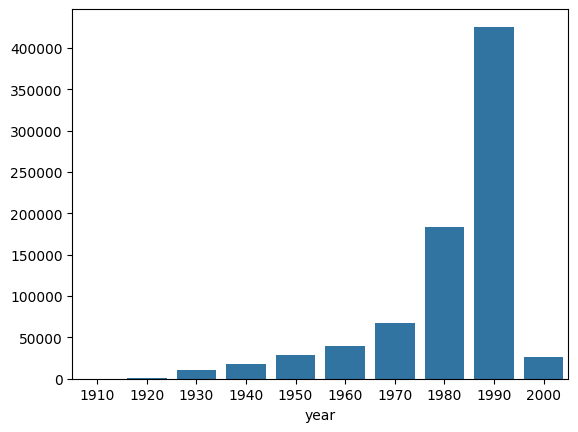

In [60]:
# 연도별 시청한 영화 수
year = train_df['year'].value_counts().sort_index()
sns.barplot(x=year.index, y=year.values)

In [61]:
train_df['main_genre'].value_counts()

,count
main_genre,
Comedy,219077
Action,210721
Drama,163949
Horror,36100
Adventure,35315
Crime,30569
Animation,29121
Children's,17088
Thriller,13974


<Axes: >

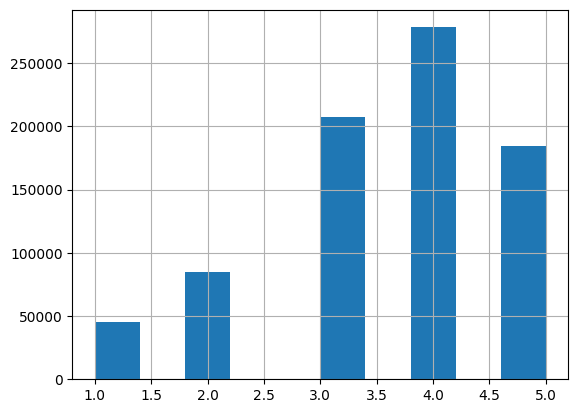

In [62]:
# 시청한 영화 점수 분포 탐색
train_df['rating'].hist()

### 문제 17. Feature Mapping - Profiling 피처맵 맵핑

In [63]:
# profile 완료된 경과로 피처맵 맵핑

train_df = train_df[['user_id', 'movie_id', 'rating', 'year', 'main_genre', 'gender', 'occupation', 'age_bucket']]
train_df['year'] = train_df['year'].apply(lambda x: year_index[x])
train_df['main_genre'] = train_df['main_genre'].apply(lambda x: genre_index[x])
train_df['gender'] = train_df['gender'].apply(lambda x: gender_index[x])
train_df['occupation'] = train_df['occupation'].apply(lambda x: occupation_index[x])
train_df['age_bucket'] = train_df['age_bucket'].apply(lambda x: age_index[x])

In [64]:
train_df.head()

,user_id,movie_id,rating,year,main_genre,gender,occupation,age_bucket
0,635,1251,4,4,5,2,9,2
1,635,3948,4,10,3,2,9,2
2,635,1270,4,3,3,2,9,2
3,635,1279,5,1,3,2,9,2
4,635,1286,4,3,5,2,9,2


In [65]:
test_df = pd.merge(test_df, movie_df, on='movie_id')
test_df = pd.merge(test_df, user_df, on='user_id')
test_df.head()

,user_id,movie_id,rating,time,title,genre,year,main_genre,gender,age,occupation,zipcode,age_bucket
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,1970,Drama,F,1,10,48067,outlier
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical,1990,Animation,F,1,10,48067,outlier
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance,1960,Musical,F,1,10,48067,outlier
3,1,3408,4,978300275,Erin Brockovich (2000),Drama,2000,Drama,F,1,10,48067,outlier
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy,1990,Animation,F,1,10,48067,outlier


In [66]:
test_df = test_df[['user_id', 'movie_id', 'rating', 'year', 'main_genre', 'gender', 'occupation', 'age_bucket']]
test_df['year'] = test_df['year'].apply(lambda x: year_index[x])
test_df['main_genre'] = test_df['main_genre'].apply(lambda x: genre_index[x])
test_df['gender'] = test_df['gender'].apply(lambda x: gender_index[x])
test_df['occupation'] = test_df['occupation'].apply(lambda x: occupation_index[x])
test_df['age_bucket'] = test_df['age_bucket'].apply(lambda x: age_index[x])

### 문제 18. Binary Transformation - 평가 점수 기준으로 (0,1) 변환

In [72]:
train_df['y'] = train_df['rating'].apply(lambda x: 1 if x >= 4 else 0)
train_df.sample(10).head()

,user_id,movie_id,rating,year,main_genre,gender,occupation,age_bucket,y
71364,1150,3074,2,2,13,1,5,3,0
622615,4858,1208,4,2,5,2,7,3,1
229714,2225,2571,3,1,4,2,19,3,0
447433,3769,3101,5,3,6,2,3,3,1
485564,3998,3695,1,3,3,2,10,4,0


In [73]:
test_df['y'] = test_df['rating'].apply(lambda x: 1 if x >= 4 else 0)
test_df.sample(10).head()

,user_id,movie_id,rating,year,main_genre,gender,occupation,age_bucket,y
84066,550,434,2,1,4,2,15,4,0
25928,183,3724,4,2,5,1,7,4,1
133130,1647,2125,3,1,5,2,18,6,0
28598,197,3538,5,1,3,2,12,6,1
31114,208,1148,4,1,1,2,9,5,1


### 문제 19. Feature Vector 생성 - libsvm 포맷의 데이터셋 생성


#### Sparse Vector in Linear Model

    [Sparse Vector]
    1. 0, 1로 값을 표현하는 벡터가 매우 희소한 상황
    2. 아래 그림에서 3002개의 벡터 중, 1이 등장하는 벡터는 단 두개
    3. Linear Model에서 Sparse 하다는 것은 이러한 상황을 의미

![sparse](https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/images/sparse.png)

----

    [Linear Model]
    1. 입력 특성에 대한 선형 함수를 만들어 예측을 수행하는 모델
    2. y = a1x1 + a2x2... 같은 방정식이라고 생각할 수 있음
    3. 일반적인 랭킹 모델은 Linear Model로 마지막 추론을 하게 되어있음
    4. x1, x2...가 바로 Sparse Vector를 의미함

----

    [libsvm 포맷]
    1. "index":"value" 형태로 sparse vector를 표현하는 형태
    2. 위 그림을 표현하면, "1:1 3001:1" 이 됨.

In [74]:
col_len_dict = {'user_id': len(train_df['user_id'].unique()),
                'movie_id': len(train_df['movie_id'].unique()),
                'year': len(train_df['year'].unique()),
                'main_genre': len(train_df['main_genre'].unique()),
                'gender': len(train_df['gender'].unique()),
                'occupation': len(train_df['occupation'].unique()),
                'age_bucket': len(train_df['age_bucket'].unique())}

col_accum_index_dict = {}
cumulative = 0

for key, value in col_len_dict.items():
    col_accum_index_dict[key] = cumulative
    cumulative = cumulative + value

In [75]:
col_accum_index_dict

{'user_id': 0,
 'movie_id': 5400,
 'year': 9062,
 'main_genre': 9072,
 'gender': 9090,
 'occupation': 9092,
 'age_bucket': 9113}

In [76]:
train_df.head()

,user_id,movie_id,rating,year,main_genre,gender,occupation,age_bucket,y
0,635,1251,4,4,5,2,9,2,1
1,635,3948,4,10,3,2,9,2,1
2,635,1270,4,3,3,2,9,2,1
3,635,1279,5,1,3,2,9,2,1
4,635,1286,4,3,5,2,9,2,1


In [79]:
for idx, row in train_df.iterrows():
  vec = []
  label = row['y']
  vec.append(str(label))
  row = row.drop(labels=['rating'])
  row = row.drop(labels=['y'])
  for key, value in row.items():
    col_idx = col_accum_index_dict[key] + value - 1
    vec.append(str(col_idx) + ":" + str(1))
  print("%s\n" % " ".join(vec))
  break

1 634:1 6650:1 9065:1 9076:1 9091:1 9100:1 9114:1



## Step 4. 추천 랭킹 모델링 (Factorization Machine)

#### Factorization Machine

![equation](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbRP7gn%2FbtqDw3LQxDB%2FXmWK8heUckUWpHx379UCM1%2Fimg.png)

    [랭킹 모델의 형태와 역할]
    1. Linear Regression, SVM처럼 동작하는 General predictor
    2. 변수 간의 모든 pair-wise interaction을 계산하는 알고리즘
    3. General predictor의 장점 + MF 알고리즘이 가지는 의미 단위 해석(latent factor)의 장점
    4. sparse한 데이터셋을 가지고 있을 때 적합

### 문제 20. 학습 데이터 생성 - 특정 시간 기준 Train/Test 데이터셋 생성

In [80]:
!pip install xlearn

In [81]:
txt_file = open('train.txt', 'w')
for idx, row in train_df.iterrows():
  vec = []
  label = row['y']
  vec.append(str(label))
  row = row.drop(labels=['rating'])
  row = row.drop(labels=['y'])
  for key, value in row.items():
    col_idx = col_accum_index_dict[key] + value - 1
    vec.append(str(col_idx) + ":" + str(1))
  txt_file.write("%s\n" % " ".join(vec))
txt_file.close()

In [82]:
txt_file = open('test.txt', 'w')
for idx, row in test_df.iterrows():
  vec = []
  label = row['y']
  vec.append(str(label))
  row = row.drop(labels=['rating'])
  row = row.drop(labels=['y'])
  for key, value in row.items():
    col_idx = col_accum_index_dict[key] + value - 1
    vec.append(str(col_idx) + ":" + str(1))
  txt_file.write("%s\n" % " ".join(vec))
txt_file.close()

### 문제 21. 모델링 - FM Binary Classification 모델 학습

In [83]:
import numpy as np
from sklearn.metrics import roc_auc_score


class FactorizationMachine():
    def __init__(self, k, lr, l2_reg, l2_lambda, epoch, early_stop_window, train_data, valid_data):
        self._k = k
        self._lr = lr
        self._l2_reg = l2_reg
        self._l2_lambda = l2_lambda
        self._epoch = epoch
        self._early_stop_window = early_stop_window
        self._train_file_path = train_data
        self._valid_file_path = valid_data
        self._valid_loss_list = []

    def _load_dataset(self):
        """
        1. load dataset to memory from train/valid path
        2. find max index in dataset for w's vector size
        """
        # load data
        train_file = open(self._train_file_path, 'r')
        valid_file = open(self._valid_file_path, 'r')
        self._train_data = train_file.read().split('\n')
        self._valid_data = valid_file.read().split('\n')
        train_file.close()
        valid_file.close()

        # find max index
        self.feature_max_index = 0
        print("Start to init FM vectors.")
        for row in self._train_data:
            for element in row.split(" ")[1:]:
                index = int(element.split(":")[0])
                if self.feature_max_index < index:
                    self.feature_max_index = index

        for row in self._valid_data:
            for element in row.split(" ")[1:]:
                index = int(element.split(":")[0])
                if self.feature_max_index < index:
                    self.feature_max_index = index

        # init FM vectors
        self._init_vectors()
        print("Finish init FM vectors.")

    def _init_vectors(self):
        """
        1. initialize FM vectors
        2. Conduct naive transformation libsvm format txt data to numpy training sample.
        """
        self.w = np.random.randn(self.feature_max_index+1)
        self.v = np.random.randn(self.feature_max_index+1, self._k)
        self.train_x_data = []
        self.train_y_data = np.zeros((len(self._train_data)-1))
        self.valid_x_data = []
        self.valid_y_data = np.zeros((len(self._valid_data)-1))

        # make numpy dataset
        for n, row in enumerate(self._train_data):
            element = row.split(" ")
            if len(element) > 1:
              self.train_y_data[n] = int(element[0])
              self.train_x_data.append([np.array([int(pair.split(":")[0]) for pair in element[1:]]),
                                        np.array([int(pair.split(":")[1]) for pair in element[1:]])])

        for n, row in enumerate(self._valid_data):
            element = row.split(" ")
            if len(element) > 1:
              self.valid_y_data[n] = int(element[0])
              self.valid_x_data.append([np.array([int(pair.split(":")[0]) for pair in element[1:]]),
                                        np.array([int(pair.split(":")[1]) for pair in element[1:]])])

    def train(self):
        """
        Train FM model by Gradient Descent with L2 regularization
        """
        self._load_dataset()
        for epoch_num in range(1, self._epoch):
            train_y_hat = self.predict(data=self.train_x_data)
            valid_y_hat = self.predict(data=self.valid_x_data)
            train_loss = self._get_loss(y_data=self.train_y_data, y_hat=train_y_hat)
            valid_loss = self._get_loss(y_data=self.valid_y_data, y_hat=valid_y_hat)
            train_auc = roc_auc_score(self.train_y_data, train_y_hat)
            valid_auc = roc_auc_score(self.valid_y_data, valid_y_hat)
            self._print_learning_info(epoch=epoch_num, train_loss=train_loss, valid_loss=valid_loss,
                                      train_auc=train_auc, valid_auc=valid_auc)
            if self._check_early_stop(valid_loss=valid_loss):
                print("Early stop at epoch:", epoch_num)
                return 0

            self._stochastic_gradient_descent(self.train_x_data, self.train_y_data)

    def predict(self, data):
        """
        Implementation of FM model's equation on O(kmd)
        -----
        Numpy array shape : (n, [index of md], [value of md])
        md : none-zero feature
        """
        num_data = len(data)
        scores = np.zeros(num_data)
        for n in range(num_data):
            feat_idx = data[n][0]
            val = data[n][1]

            # linear feature score
            linear_feature_score = np.sum(self.w[feat_idx] * val)

            # factorized feature score
            vx = self.v[feat_idx] * (val.reshape(-1, 1))
            cross_sum = np.sum(vx, axis=0)
            square_sum = np.sum(vx * vx, axis=0)
            cross_feature_score = 0.5 * np.sum(np.square(cross_sum) - square_sum)

            # Model's equation
            scores[n] = linear_feature_score + cross_feature_score

        # Sigmoid transformation for binary classification
        scores = 1.0 / (1.0 + np.exp(-scores))
        return scores

    def _get_loss(self, y_data, y_hat):
        """
        Calculate loss with L2 regularization (two type of coeficient - w,v)
        """
        l2_norm = 0
        if self._l2_reg:
            w_norm = np.sqrt(np.sum(np.square(self.w)))
            v_norm = np.sqrt(np.sum(np.square(self.v)))
            l2_norm = self._l2_lambda * (w_norm + v_norm)
        return -1 * np.sum( (y_data * np.log(y_hat)) + ((1 - y_data) * np.log(1 - y_hat)) ) + l2_norm

    def _check_early_stop(self, valid_loss):
        self._valid_loss_list.append(valid_loss)
        if len(self._valid_loss_list) > 5:
            prev_loss = self._valid_loss_list[len(self._valid_loss_list) - self._early_stop_window]
            curr_loss = valid_loss
            if prev_loss < curr_loss:
                return True
        return False

    def _print_learning_info(self, epoch, train_loss, valid_loss, train_auc, valid_auc):
        print("epoch:", epoch, "||", "train_loss:", train_loss, "||", "valid_loss:", valid_loss,
              "||", "Train AUC:", train_auc, "||", "Test AUC:", valid_auc)


    def _stochastic_gradient_descent(self, x_data, y_data):
        """
        Update each coefs (w, v) by Gradient Descent
        """
        for data, y in zip(x_data, y_data):
            feat_idx = data[0]
            val = data[1]
            vx = self.v[feat_idx] * (val.reshape(-1, 1))

            # linear feature score
            linear_feature_score = np.sum(self.w[feat_idx] * val)

            # factorized feature score
            vx = self.v[feat_idx] * (val.reshape(-1, 1))
            cross_sum = np.sum(vx, axis=0)
            square_sum = np.sum(vx * vx, axis=0)
            cross_feature_score = 0.5 * np.sum(np.square(cross_sum) - square_sum)

            # Model's equation
            score = linear_feature_score + cross_feature_score
            y_hat = 1.0 / (1.0 + np.exp(-score))
            cost = y_hat - y

            if self._l2_reg:
                self.w[feat_idx] = self.w[feat_idx] - cost * self._lr * (val + self._l2_lambda * self.w[feat_idx])
                self.v[feat_idx] = self.v[feat_idx] - cost * self._lr * ((sum(vx) * (val.reshape(-1, 1)) - (vx * (val.reshape(-1, 1)))) + self._l2_lambda * self.v[feat_idx])
            else:
                self.w[feat_idx] = self.w[feat_idx] - cost * self._lr * val
                self.v[feat_idx] = self.v[feat_idx] - cost * self._lr * (sum(vx) * (val.reshape(-1, 1)) - (vx * (val.reshape(-1, 1))))

### 문제 22. 모델링 - AUC 평가

In [84]:
fm = FactorizationMachine(k=4,
                          lr=0.005,
                          l2_reg=True,
                          l2_lambda=0.0002,
                          epoch=30,
                          early_stop_window=3,
                          train_data='./train.txt',
                          valid_data='./test.txt')
fm.train()

Start to init FM vectors.
Finish init FM vectors.


<ipython-input-83-c64cbc6f546d>:134: RuntimeWarning: divide by zero encountered in log
  return -1 * np.sum( (y_data * np.log(y_hat)) + ((1 - y_data) * np.log(1 - y_hat)) ) + l2_norm
<ipython-input-83-c64cbc6f546d>:134: RuntimeWarning: invalid value encountered in multiply
  return -1 * np.sum( (y_data * np.log(y_hat)) + ((1 - y_data) * np.log(1 - y_hat)) ) + l2_norm


epoch: 1 || train_loss: nan || valid_loss: nan || Train AUC: 0.4888854978650888 || Test AUC: 0.4931944575941357
epoch: 2 || train_loss: 772462.7037687118 || valid_loss: 203391.04465997708 || Train AUC: 0.5809785536538283 || Test AUC: 0.5733562304016251
epoch: 3 || train_loss: 673008.2985620787 || valid_loss: 181491.05068539333 || Train AUC: 0.6156728944892302 || Test AUC: 0.5972551628039252
epoch: 4 || train_loss: 620403.2051773955 || valid_loss: 169510.30316684142 || Train AUC: 0.6400972751502173 || Test AUC: 0.6141530984467458
epoch: 5 || train_loss: 587699.5545092669 || valid_loss: 162139.27541298355 || Train AUC: 0.6584930752408417 || Test AUC: 0.6269630746389869
epoch: 6 || train_loss: 565560.4612387562 || valid_loss: 157341.24461380063 || Train AUC: 0.672748911383824 || Test AUC: 0.636727277757332
epoch: 7 || train_loss: 549690.1267382643 || valid_loss: 154097.29775734528 || Train AUC: 0.683981727032397 || Test AUC: 0.6441036625247549
epoch: 8 || train_loss: 537696.4444727808 || 

0

## Step 5. 모의 추천 시스템 구축

### 문제 23. 추천 결과 평가 - 특정 시간 기준 유저별 시청 목록 추출 (Train/Test과 동일 기준)

In [85]:
# train 데이터셋에서 유처 시청 목록 추출
def get_movie_list_sort_by_time(x):
  return x.sort_values(['time'])['movie_id'].tolist()

train_user_watch_list = rating_df[rating_df['time'] < tt].groupby('user_id')[['movie_id', 'time']].apply(lambda x: get_movie_list_sort_by_time(x))

### 문제 24. 추천 결과 평가 - Train 데이터 기반 유저별 추천 후보군 생성

#### 1) 최근 시청한 3개 영화의 연관 영화 목록 추출

In [86]:
# train 데이터셋으로만 m2v 모델 학습
# train 데이터셋으로만 m2v 학습
m2v_train_df = pd.merge(rating_df[rating_df['time'] < tt], movie_df, on='movie_id')
m2v_train_df.head()

,user_id,movie_id,rating,time,title,genre,year,main_genre
0,635,1251,4,975768620,8 1/2 (1963),Drama,1960,Drama
1,635,3948,4,975768294,Meet the Parents (2000),Comedy,2000,Comedy
2,635,1270,4,975768106,Back to the Future (1985),Comedy|Sci-Fi,1980,Comedy
3,635,1279,5,975768520,Night on Earth (1991),Comedy|Drama,1990,Comedy
4,635,1286,4,975768106,Somewhere in Time (1980),Drama|Romance,1980,Drama


In [88]:
movie_meta_dict = m2v_train_df.set_index('movie_id')[['year', 'main_genre']].to_dict()

In [90]:
# 유저별 최근 시청한 3개 영화 추출

def get_recent_movie_list_sort_by_time(x, k):
  return x.sort_values(['time'])['movie_id'].tolist()[-k:]

recent_user_watch_list = rating_df[rating_df['time'] < tt].groupby('user_id')[['movie_id', 'time']].apply(lambda x: get_recent_movie_list_sort_by_time(x, 3))

In [91]:
recent_user_watch_list

,0
user_id,
635,"[1884, 2966, 3198]"
636,"[1391, 1690, 3156]"
637,"[1378, 1278, 1379]"
638,"[1587, 2193, 3863]"
639,"[2762, 3114, 2987]"
...,...
6036,"[1862, 2807, 3574]"
6037,"[2641, 968, 435]"
6038,"[1419, 2700, 1183]"


In [93]:
def get_similar_items(x, k):
  similar_items = []
  for movie_id in x:
    if movie_id in item2item:
      similar_items.append(item2item[movie_id][:k])
  return [item for items in similar_items for item in items]

recent_watch_similar_items = recent_user_watch_list.apply(lambda x: get_similar_items(x, 5))

In [94]:
recent_watch_similar_items

,0
user_id,
635,"[372, 333, 663, 2447, 639, 3006, 1041, 3083, 9..."
636,"[379, 442, 780, 1676, 466, 1320, 1762, 2525, 1..."
637,"[368, 2478, 2989, 2376, 1379, 1080, 1136, 1997..."
638,"[434, 2376, 2990, 2370, 2405, 2105, 2005, 2161..."
639,"[1358, 2840, 2841, 2692, 3006, 2700, 1148, 122..."
...,...
6036,"[2448, 519, 3665, 3573, 3664, 546, 692, 1720, ..."
6037,"[1375, 3698, 2105, 3704, 2094, 2901, 2553, 255..."
6038,"[3152, 3201, 3359, 1955, 3498, 2395, 3114, 1, ..."


#### 2) 평점 기반 인기 영화

In [95]:
# 평점 높은 상위 10개의 영화 추출
mean_ratings = rating_df[rating_df['time'] <tt].groupby('movie_id')['rating'].agg(['mean', 'count'])

In [97]:
# 평점 높은 상위 10개 영화
popular_movie_list = mean_ratings[mean_ratings['count']>10]['mean'].sort_values(ascending=False).index[:10].tolist()
popular_movie_list

[2905, 2019, 318, 922, 745, 50, 858, 1148, 527, 1178]

#### 3) 장르, 연도별 인기 영화

In [99]:
merge_df = pd.merge(mean_ratings, movie_df, on='movie_id')
merge_df.head()

,movie_id,mean,count,title,genre,year,main_genre
0,1,4.145714,1750,Toy Story (1995),Animation|Children's|Comedy,1990,Animation
1,2,3.197880,566,Jumanji (1995),Adventure|Children's|Fantasy,1990,Adventure
2,3,3.023560,382,Grumpier Old Men (1995),Comedy|Romance,1990,Comedy
3,4,2.701493,134,Waiting to Exhale (1995),Comedy|Drama,1990,Comedy
4,5,2.995781,237,Father of the Bride Part II (1995),Comedy,1990,Comedy


In [101]:
# 장르&연도를 meta로 하여, meta별 상위 10개의 평점 높은 영화
def get_meta_popular_list(x, k):
  movie_id_list = x.sort_values(by=['mean'], ascending=False)['movie_id'].tolist()
  return movie_id_list[:k]

genre_popular = merge_df.groupby('main_genre').apply(lambda x: get_meta_popular_list(x, k=10))
year_popular = merge_df.groupby('year').apply(lambda x: get_meta_popular_list(x, k=10))

<ipython-input-101-7348aff07958>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  genre_popular = merge_df.groupby('main_genre').apply(lambda x: get_meta_popular_list(x, k=10))
<ipython-input-101-7348aff07958>:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  year_popular = merge_df.groupby('year').apply(lambda x: get_meta_popular_list(x, k=10))


In [102]:
genre_popular

,0
main_genre,
Action,"[2905, 2019, 858, 1198, 260, 1221, 2028, 2571,..."
Adventure,"[3172, 1204, 1262, 1254, 919, 3470, 1303, 1259..."
Animation,"[745, 1148, 720, 3429, 1223, 3114, 1, 741, 281..."
Children's,"[1026, 1097, 1028, 34, 262, 3396, 3397, 531, 9..."
Comedy,"[3233, 3607, 1830, 3232, 2444, 3030, 3307, 341..."
Crime,"[3656, 50, 3517, 3435, 1260, 296, 1213, 608, 1..."
Documentary,"[3881, 787, 2930, 1149, 3338, 1147, 3679, 128,..."
Drama,"[989, 3522, 2964, 1471, 3382, 53, 1664, 2503, ..."
Fantasy,"[792, 2021]"


In [103]:
year_popular

,0
year,
1910,"[3132, 2823, 2821]"
1920,"[3232, 3517, 3306, 3022, 3140, 3629, 2010, 374..."
1930,"[3382, 3307, 3134, 1260, 950, 905, 919, 3462, ..."
1940,"[3656, 1212, 3435, 923, 912, 913, 3089, 2937, ..."
1950,"[3172, 2019, 922, 1178, 904, 670, 1250, 908, 2..."
1960,"[3233, 2905, 557, 750, 3030, 1207, 1204, 1262,..."
1970,"[3607, 3522, 858, 260, 1193, 1221, 1136, 1252,..."
1980,"[1198, 3338, 1131, 3091, 541, 3679, 1233, 1197..."
1990,"[989, 1471, 2964, 1830, 787, 53, 1664, 2503, 2..."


#### 4) 4개 추천 후보군 병합

In [104]:
# 위에서 추출한 후보군들을 하나로 병합
recent_watch_similar_items.apply(lambda x: x.extend(popular_movie_list))

,0
user_id,
635,None
636,None
637,None
638,None
639,None
...,...
6036,None
6037,None
6038,None


##### 유저별 선호 장르/연도 파악

In [ ]:
# 1. 유저별 시청 히스토리를 기준으로 선호하는 장르/연도 지정
# 2. 선호하는 장르/연도의 인기 리스트 추출

In [105]:
train_user_watch_list

,0
user_id,
635,"[2294, 480, 920, 3614, 1270, 1286, 3528, 3948,..."
636,"[2123, 1721, 110, 1210, 2193, 1197, 2746, 3693..."
637,"[908, 1376, 2792, 2085, 1203, 924, 1019, 965, ..."
638,"[1210, 1978, 2716, 2617, 788, 2555, 2532, 3555..."
639,"[2028, 2944, 1961, 1363, 2634, 1198, 2571, 589..."
...,...
6036,"[1721, 2376, 3438, 2428, 1883, 2492, 2827, 268..."
6037,"[1882, 2028, 1267, 702, 3508, 562, 3148, 858, ..."
6038,"[920, 3396, 1210, 2146, 356, 1387, 1079, 1148,..."


In [106]:
movie_dict = merge_df[['movie_id', 'year', 'main_genre']].to_dict()

In [107]:
from collections import Counter

def most_frequent(x):
    occurence_count = Counter(x)
    return occurence_count.most_common(1)[0][0]

def get_items_by_prefer_meta(x):
  year_list = []
  genre_list = []
  for movie_id in x:
    if movie_id in movie_dict['year']:
      year_list.append(movie_dict['year'][movie_id])
    if movie_id in movie_dict['main_genre']:
      genre_list.append(movie_dict['main_genre'][movie_id])
  prefer_year = most_frequent(year_list)
  prefer_genre = most_frequent(genre_list)
  return year_popular[prefer_year] + genre_popular[prefer_genre]

In [108]:
items_by_prefer_meta = train_user_watch_list.apply(lambda x: get_items_by_prefer_meta(x))

In [109]:
items_by_prefer_meta.sample(10)

,0
user_id,
5236,"[989, 1471, 2964, 1830, 787, 53, 1664, 2503, 2..."
6012,"[989, 1471, 2964, 1830, 787, 53, 1664, 2503, 2..."
4840,"[989, 1471, 2964, 1830, 787, 53, 1664, 2503, 2..."
2084,"[989, 1471, 2964, 1830, 787, 53, 1664, 2503, 2..."
3908,"[989, 1471, 2964, 1830, 787, 53, 1664, 2503, 2..."
5200,"[989, 1471, 2964, 1830, 787, 53, 1664, 2503, 2..."
4280,"[989, 1471, 2964, 1830, 787, 53, 1664, 2503, 2..."
1383,"[989, 1471, 2964, 1830, 787, 53, 1664, 2503, 2..."
3153,"[989, 1471, 2964, 1830, 787, 53, 1664, 2503, 2..."


##### 최종 병합

In [110]:
merged_candidates = recent_watch_similar_items + items_by_prefer_meta

In [111]:
recommendations = merged_candidates.apply(lambda x: set(x))

### 문제 25. 추천 결과 평가 - 랭킹 모델로 추천 후보군 K개 정렬

#### predict 가능한 포맷으로 변경
- ex) [[array([31, 55, 66, 77]), array([1, 1, 1, 1])]]

In [112]:
movie_df['year'] = movie_df['year'].apply(lambda x: year_index[x])
movie_df['main_genre'] = movie_df['main_genre'].apply(lambda x: genre_index[x])
movie_df = movie_df[['movie_id', 'year', 'main_genre']]
movie_df.head()

,movie_id,year,main_genre
0,1,1,1
1,2,1,2
2,3,1,3
3,4,1,3
4,5,1,3


In [113]:
user_df['gender'] = user_df['gender'].apply(lambda x: gender_index[x])
user_df['occupation'] = user_df['occupation'].apply(lambda x: occupation_index[x])
user_df['age_bucket'] = user_df['age_bucket'].apply(lambda x: age_index[x])
user_df = user_df[['user_id', 'gender', 'age_bucket', 'occupation']]
user_df.head()

,user_id,gender,age_bucket,occupation
0,1,1,1,1
1,2,2,2,2
2,3,2,3,3
3,4,2,4,4
4,5,2,3,5


In [114]:
movie_index_dict = movie_df.set_index('movie_id')[['year', 'main_genre']].to_dict()
str(movie_index_dict)[:300]

"{'year': {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1"

In [115]:
user_index_dict = user_df.set_index('user_id')[['gender', 'age_bucket', 'occupation']].to_dict()
str(user_index_dict)[:300]

"{'gender': {1: 1, 2: 2, 3: 2, 4: 2, 5: 2, 6: 1, 7: 2, 8: 2, 9: 2, 10: 1, 11: 1, 12: 2, 13: 2, 14: 2, 15: 2, 16: 1, 17: 2, 18: 1, 19: 2, 20: 2, 21: 2, 22: 2, 23: 2, 24: 1, 25: 2, 26: 2, 27: 2, 28: 1, 29: 2, 30: 1, 31: 2, 32: 1, 33: 2, 34: 1, 35: 2, 36: 2, 37: 1, 38: 1, 39: 2, 40: 2, 41: 1, 42: 2, 43:"

In [118]:
def make_libsvm_row(uid, mid):
  row = []
  user_id = str(col_accum_index_dict['user_id'] + uid - 1) + ":" + str(1)
  gender = str(col_accum_index_dict['gender'] + user_index_dict['gender'][uid] - 1) + ":" + str(1)
  age_bucket = str(col_accum_index_dict['age_bucket'] + user_index_dict['age_bucket'][uid] - 1) + ":" + str(1)
  occupation = str(col_accum_index_dict['occupation'] + user_index_dict['occupation'][uid] - 1) + ":" + str(1)
  movie_id = str(col_accum_index_dict['movie_id'] + int(mid) - 1) + ":" + str(1)
  year = str(col_accum_index_dict['year'] + movie_index_dict['year'][int(mid)] - 1) + ":" + str(1)
  main_genre = str(col_accum_index_dict['main_genre'] + movie_index_dict['main_genre'][int(mid)] - 1) + ":" + str(1)
  return " ".join([user_id, gender, age_bucket, occupation, movie_id, year, main_genre])

In [121]:
# make vector list
vector_list = []
uid_mid_list = []
for uid, movie_set in recommendations.items():
  for mid in movie_set:
    x_feature = []
    libsvm_row = make_libsvm_row(uid, mid)
    element = libsvm_row.split(" ")
    vector_list.append([np.array([int(pair.split(":")[0]) for pair in element]), np.array([int(pair.split(":")[1]) for pair in element])])
    uid_mid_list.append((uid, mid))

In [122]:
vector_list[0]

[array([ 634, 9091, 9114, 9100, 7063, 9062, 9076]),
 array([1, 1, 1, 1, 1, 1, 1])]

In [123]:
uid_mid_list[0]

(635, 1664)

In [124]:
predict_results = fm.predict(vector_list)

In [125]:
predict_results

array([0.61379095, 0.94935578, 0.38138986, ..., 0.52526071, 0.38306502,
       0.93318813])

#### 후보군 정렬

In [126]:
# 유저별 추천 후보군 재정렬

user_recommendation_dict = {}
for watch_prob, uid_mid in zip(predict_results, uid_mid_list):
  uid, mid = int(uid_mid[0]), int(uid_mid[1])
  if uid not in user_recommendation_dict:
    user_recommendation_dict[uid] = {}
    user_recommendation_dict[uid][mid] = watch_prob
  else:
    if mid not in user_recommendation_dict[uid]:
      user_recommendation_dict[uid][mid] = watch_prob

In [127]:
str(user_recommendation_dict)[:2000]

'{635: {1664: 0.61379094953104, 3498: 0.9493557818072348, 1082: 0.38138986451662366, 3194: 0.765225178900865, 2444: 0.9336119369210842, 639: 0.8616307396570321, 994: 0.9784047957789471, 527: 0.9893205445256599, 787: 0.9998241800587332, 2964: 0.9140881015896554, 922: 0.9988818191282223, 1178: 0.9787217972924088, 3006: 0.9535383276673263, 1830: 0.9821055830730234, 372: 0.7506777460029004, 50: 0.7419670701490332, 53: 0.9486359472132007, 3382: 0.2832650264916769, 1041: 0.9816667230363683, 318: 0.9800025553420149, 1471: 0.6829903641454912, 3522: 0.11476560620550384, 2503: 0.9798768724621285, 333: 0.531616828026301, 663: 0.8068268117217109, 1955: 0.9701010463927766, 3152: 0.9581368440792241, 2905: 0.8782144541943675, 858: 0.9814283868060538, 989: 0.5432531894969841, 2447: 0.4161689357944528, 3083: 0.8683860606476649, 2019: 0.9910150212967122, 745: 0.9878940559717914, 2930: 0.18517384330636477, 1148: 0.9867059113615002, 3163: 0.8909006656281914}, 636: {1762: 0.21861218641767124, 1664: 0.98464

## Step 6. 추천 결과 평가

### 문제 26. 추천 결과 평가 - 추천 후보군과 Test 데이터간의 MAP@K 계산

In [136]:
# 4점 이상을 준 test 시청리스트 추출, MAP 계산
user_actual_watch_list = rating_df[(rating_df['time'] < tt) & (rating_df['rating'] >= 4)].groupby('user_id')['movie_id'].apply(lambda x: x.tolist())

In [137]:
user_actual_watch_list

,movie_id
user_id,
635,"[1251, 3948, 1270, 1279, 1286, 3035, 920, 3067..."
636,"[2054, 589, 1261, 780, 968, 2455, 1653, 2460, ..."
637,"[2987, 3930, 3932, 3791, 1250, 2054, 1252, 125..."
638,"[2987, 3793, 1259, 592, 1270, 1275, 1285, 3039..."
639,"[2058, 589, 1408, 733, 592, 1275, 913, 3062, 1..."
...,...
6036,"[589, 3006, 3008, 2064, 2069, 590, 593, 594, 5..."
6037,"[3006, 2064, 593, 903, 904, 908, 909, 910, 912..."
6038,"[1419, 3088, 232, 1136, 1148, 1183, 2146, 3548..."


In [138]:
estimated_list = user_recommendation_dict[635].copy()
sorted_list = sorted(estimated_list.items(), key=lambda t : t[1], reverse=True)
top_k_list = [tup[0] for tup in sorted_list][:10]

In [139]:
user_metric = []

# 유저별 k개의 선호 리스트 추출
k = 3
for user in user_recommendation_dict:
  try:
    estimated_list = user_recommendation_dict[user].copy()
    sorted_list = sorted(estimated_list.items(), key=lambda t : t[1], reverse=True)
    top_k_list = [tup[0] for tup in sorted_list][:k]
    user_metric.append((user, top_k_list, user_actual_watch_list[user]))
  except:
    print("list index out of range, exclude user " + str(user))

list index out of range, exclude user 1160
list index out of range, exclude user 3598
list index out of range, exclude user 4467
list index out of range, exclude user 4486


In [140]:
def get_map(user_list):
  precision_list = []
  for user in user_list:
    predictive_values = user[1]
    actual_values = set(user[2])
    tp = [pv for pv in predictive_values if pv in actual_values]
    precision = len(tp) / len(predictive_values)
    precision_list.append(precision)
  return sum(precision_list) / len(precision_list)

In [141]:
get_map(user_metric)

0.08617494440326079

In [142]:
def get_map_topk(k):
  user_metric = []
  for user in user_recommendation_dict:
    try:
      estimated_list = user_recommendation_dict[user].copy()
      sorted_list = sorted(estimated_list.items(), key=lambda t : t[1], reverse=True)
      top_k_list = [tup[0] for tup in sorted_list][:k]
      user_metric.append((user, top_k_list, user_actual_watch_list[user]))
    except:
      print("list index out of range, exclude user " + str(user))

  precision_list = []
  for user in user_metric:
    predictive_values = user[1]
    actual_values = set(user[2])
    tp = [pv for pv in predictive_values if pv in actual_values]
    precision = len(tp) / len(predictive_values)
    precision_list.append(precision)
  return sum(precision_list) / len(precision_list)

In [143]:
k_param_list = range(1,30)
map_list = []
for k in k_param_list:
  map_list.append(get_map_topk(k))

list index out of range, exclude user 1160
list index out of range, exclude user 3598
list index out of range, exclude user 4467
list index out of range, exclude user 4486
list index out of range, exclude user 1160
list index out of range, exclude user 3598
list index out of range, exclude user 4467
list index out of range, exclude user 4486
list index out of range, exclude user 1160
list index out of range, exclude user 3598
list index out of range, exclude user 4467
list index out of range, exclude user 4486
list index out of range, exclude user 1160
list index out of range, exclude user 3598
list index out of range, exclude user 4467
list index out of range, exclude user 4486
list index out of range, exclude user 1160
list index out of range, exclude user 3598
list index out of range, exclude user 4467
list index out of range, exclude user 4486
list index out of range, exclude user 1160
list index out of range, exclude user 3598
list index out of range, exclude user 4467
list index 

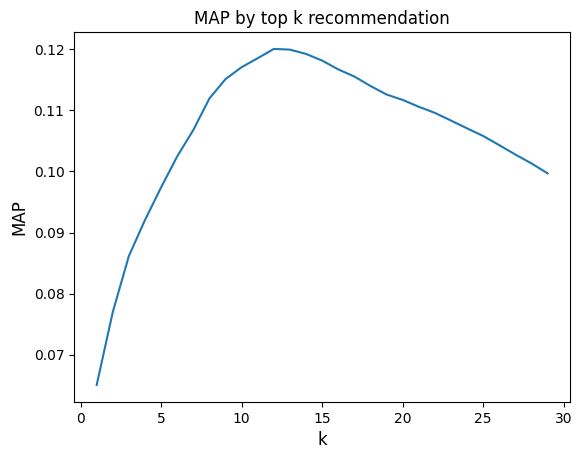

In [144]:
# map@k 시각화

plt.plot(k_param_list, map_list)
plt.title('MAP by top k recommendation')
plt.ylabel('MAP', fontsize=12)
plt.xlabel('k', fontsize=12)
plt.show()

# 결론

## 해석
X축 (k): 사용자에게 추천하는 아이템 개수, 즉 Top-k에서의 k 값 (1부터 30까지 변화)

Y축 (MAP): 각 k에 대해 계산된 Mean Average Precision (MAP) 값

## 특징
사용자별 추천 결과의 정밀도(Precision) 평균을 의미

k = 10~13일 때 MAP이 가장 높음

이 구간에서 추천 품질이 최고에 도달

추천 수가 너무 적지도 많지도 않을 때, 가장 효율적인 추천이 이루어짐

k가 작을수록 MAP이 낮음 충분한 정보 부족
추천 아이템 수가 너무 적으면 실제로 맞춘 아이템이 적어 평균 정확도가 낮아짐.

k가 너무 커지면 MAP이 감소

추천 아이템이 많아지면서 정확한 아이템 외에 부정확한 추천이 포함되기 시작

Precision이 희석될 수 있음

## 인사이트
상위 소수의 아이템 추천은 매우 잘 수행함

추천 개수가 증가할수록 불필요하거나 정확도가 낮은 아이템이 포함되는 경향이 있음

실서비스에서는 사용자 경험과 정확도 간의 균형을 고려해 Top-10~15 추천이 적절할 것으로 보임

## 결론
추천 품질은 k가 작을 때 더 뛰어나다.

Top-10 추천 정도에서 가장 높은 MAP을 달성하며,

너무 많은 추천은 Precision을 떨어뜨릴 수 있으므로 서비스 목적에 맞는 k 값을 선택하는 것이 중요하다.